<a href="https://colab.research.google.com/github/elliemmiller/datascience/blob/main/Module2FinalPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Module 2 Final Pass Assignment**

Produced by: Ellie Miller


The purpose of this assignment is to try out three different unsupervised learning methods on the dataset used for the previous assignment and apply peer feedback from the reviw assignment. I am using the World Glacier Inventory Dataset from NSIDC, which is publically available on Kaggle.

The World Glacier Inventory contains information for over 130,000 glaciers. Inventory parameters include geographic location, area, length, orientation, elevation, and classification. The WGI is based primarily on aerial photographs and maps with most glaciers having one data entry only. The data set can be viewed as a snapshot of the glacier distribution in the second half of the twentieth century. It was founded on the original WGI from the World Glacier Monitoring Service.

**Set Up**

In [2]:
!pip install umap-learn

# Import necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# Access the API to load the dataset and save it as a ZIP
!kaggle datasets download -d nsidcorg/glacier-inventory

with zipfile.ZipFile("glacier-inventory.zip", 'r') as zip_ref:
    zip_ref.extractall("glacier-inventory")

Dataset URL: https://www.kaggle.com/datasets/nsidcorg/glacier-inventory
License(s): CC0-1.0
glacier-inventory.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Load the database file
worldglacierinventory = pd.read_csv('/content/glacier-inventory/database.csv')

<ipython-input-3-14ea40a94235>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  worldglacierinventory = pd.read_csv('/content/glacier-inventory/database.csv')


In [4]:
# Select only the columns with useful data for ML approaches-removed elevation per Thomas's suggestion
worldglacierinventoryremove = worldglacierinventory[['Glacier Area', 'Mean Length', 'Mean Width', 'Mean Depth']]

# Remove any row with no data
worldglacierinventorycondense = worldglacierinventoryremove.dropna()
worldglacierinventorycondense.shape

(39089, 4)

I removed any sort of column that contained elevation data based on a recommendation from Thomas Martin.

**Initial Exploratory Data Analysis**

In [5]:
worldglacierinventory.shape

(132890, 39)

In [6]:
worldglacierinventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132890 entries, 0 to 132889
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Glacier ID                   132890 non-null  object 
 1   Political Unit               132890 non-null  object 
 2   Continent                    132890 non-null  object 
 3   Basin Code                   132890 non-null  object 
 4   Location Code                132890 non-null  object 
 5   Glacier Code                 132890 non-null  object 
 6   Glacier Name                 46751 non-null   object 
 7   Latitude                     132890 non-null  float64
 8   Longitude                    132890 non-null  float64
 9   Primary Class                131406 non-null  float64
 10  Glacier Source               132746 non-null  float64
 11  Basin Count                  15558 non-null   float64
 12  Glacier Form                 131813 non-null  float64
 13 

In [7]:
worldglacierinventory.describe()

,Latitude,Longitude,Primary Class,Glacier Source,Basin Count,Glacier Form,Glacier Activity,Activity Start,Activity End,Minimum Elevation,...,Mean Width,Mean Length,Maximum Length,Maximum Length Exposed,Maximum Length Ablation,Mean Depth,Depth Accuracy,Topographic Map Year,Topographic Map Scale,Photograph Year
count,132890.000000,132890.000000,131406.000000,132746.000000,15558.000000,131813.000000,132775.000000,4202.000000,143.000000,117162.000000,...,69966.000000,55258.000000,102593.000000,84621.000000,17051.000000,70071.000000,78685.000000,83697.000000,74586.000000,82464.000000
mean,36.322101,31.902296,5.716231,0.864712,1.031752,3.738918,0.620448,1967.112327,1986.930070,3502.362063,...,0.563436,1.392470,1.417326,1.328634,1.621133,28.415085,2.262960,1970.529565,96838.461508,1974.795899
std,27.821062,83.860643,1.768668,0.494326,0.327473,2.255064,1.072336,11.348193,6.999648,1735.317842,...,0.643816,2.087975,2.560785,1.984061,3.286073,46.480501,0.999009,10.276403,69675.200534,14.107653
min,-71.657200,-179.918000,0.000000,0.000000,1.000000,0.000000,0.000000,1901.000000,1958.000000,0.000000,...,0.000000,0.020000,0.060000,0.000000,0.000000,0.000000,1.000000,1901.000000,750.000000,1900.000000
25%,30.616000,-50.375000,6.000000,1.000000,1.000000,3.000000,0.000000,1963.000000,1986.000000,1800.000000,...,0.300000,0.500000,0.500000,0.500000,0.200000,12.000000,1.000000,1966.000000,50000.000000,1968.000000
50%,38.580000,75.484500,6.000000,1.000000,1.000000,4.000000,0.000000,1967.000000,1986.000000,3840.000000,...,0.400000,0.800000,0.800000,0.800000,0.600000,20.000000,2.000000,1972.000000,90000.000000,1971.000000
75%,49.223000,85.265750,7.000000,1.000000,1.000000,5.000000,1.000000,1975.000000,1988.000000,5020.000000,...,0.700000,1.510000,1.500000,1.500000,2.000000,36.000000,3.000000,1978.000000,100000.000000,1980.000000
max,89.300000,179.680000,9.000000,3.000000,7.000000,9.000000,8.000000,1996.000000,2002.000000,8047.000000,...,29.800000,76.640000,145.000000,125.000000,64.500000,7060.000000,5.000000,1998.000000,1000000.000000,2003.000000


**Expanded EDA**

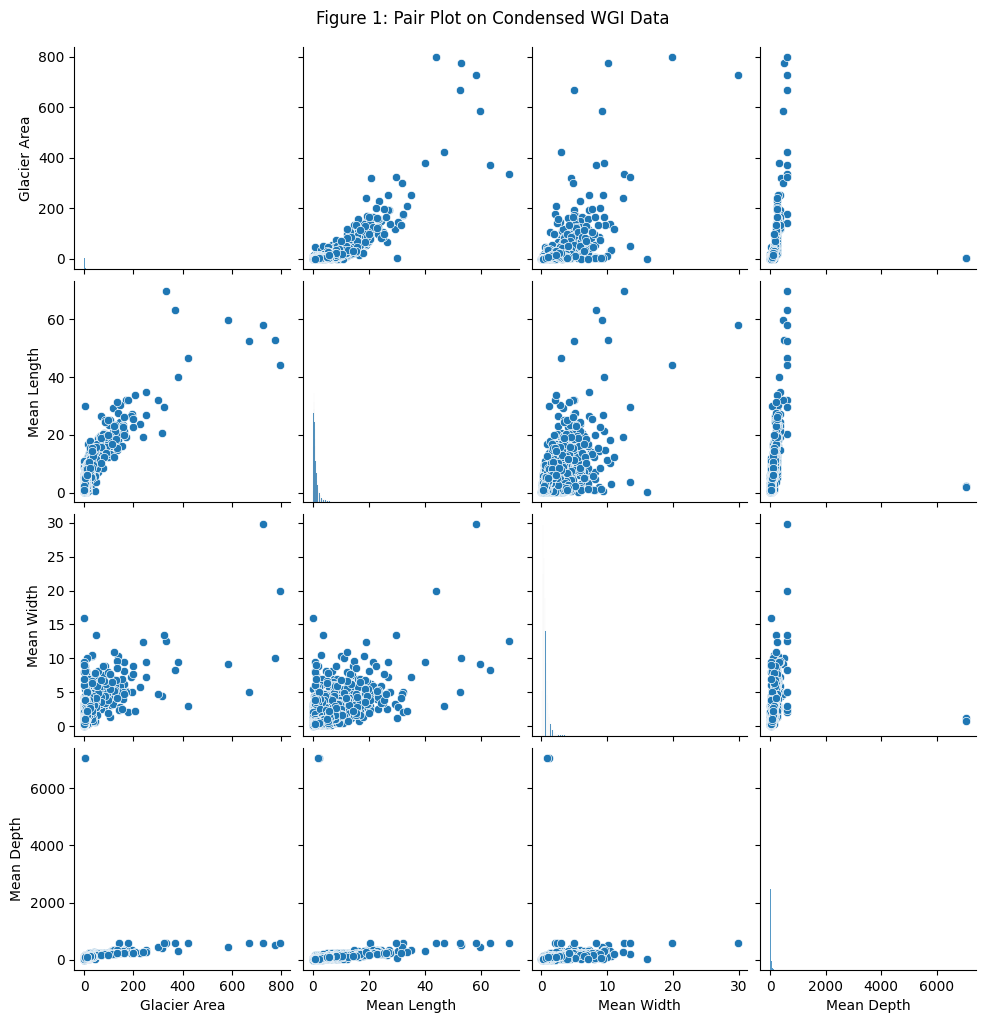

In [8]:
# Run pairplot on data
sns.pairplot(worldglacierinventorycondense)
plt.suptitle("Figure 1: Pair Plot on Condensed WGI Data", y=1.02)
plt.show()

The pair plots reveal strong positive correlations among glacier area, mean length, width, and depth, indicating that larger glaciers tend to be proportionally longer, wider, and deeper. Most glaciers cluster at smaller dimensions, highlighting the dominance of small glaciers in the dataset, while a few notable outliers represent exceptionally large glaciers. The variability across dimensions suggests regional or morphological differences, with the outliers offering potential case studies for further investigation. Overall, the plots underscore consistent scaling relationships among glacier metrics, while also pointing to possible data collection biases or unique glacier characteristics.

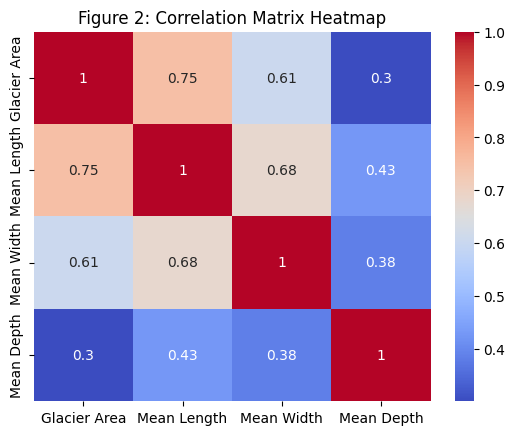

In [9]:
# Calculate the correlation matrix
corr_matrix = worldglacierinventorycondense.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Figure 2: Correlation Matrix Heatmap')
plt.show()

The correlation matrix heatmap highlights strong positive relationships among glacier area, mean length, and mean width, with correlation coefficients ranging from 0.61 to 0.75, indicating that larger glaciers tend to be proportionally longer and wider. However, mean depth shows weaker correlations with other variables (0.30 to 0.43), suggesting that glacier depth varies more independently of area, length, or width. This variability in depth might be influenced by regional or geological factors. The heatmap provides a clear overview of how glacier dimensions are interrelated, with area, length, and width exhibiting the strongest mutual dependencies.

In [10]:
# Select only numeric columns
numeric_columns = worldglacierinventorycondense.select_dtypes(include=[np.number]).columns
numeric_data = worldglacierinventorycondense.select_dtypes(include=[np.number])

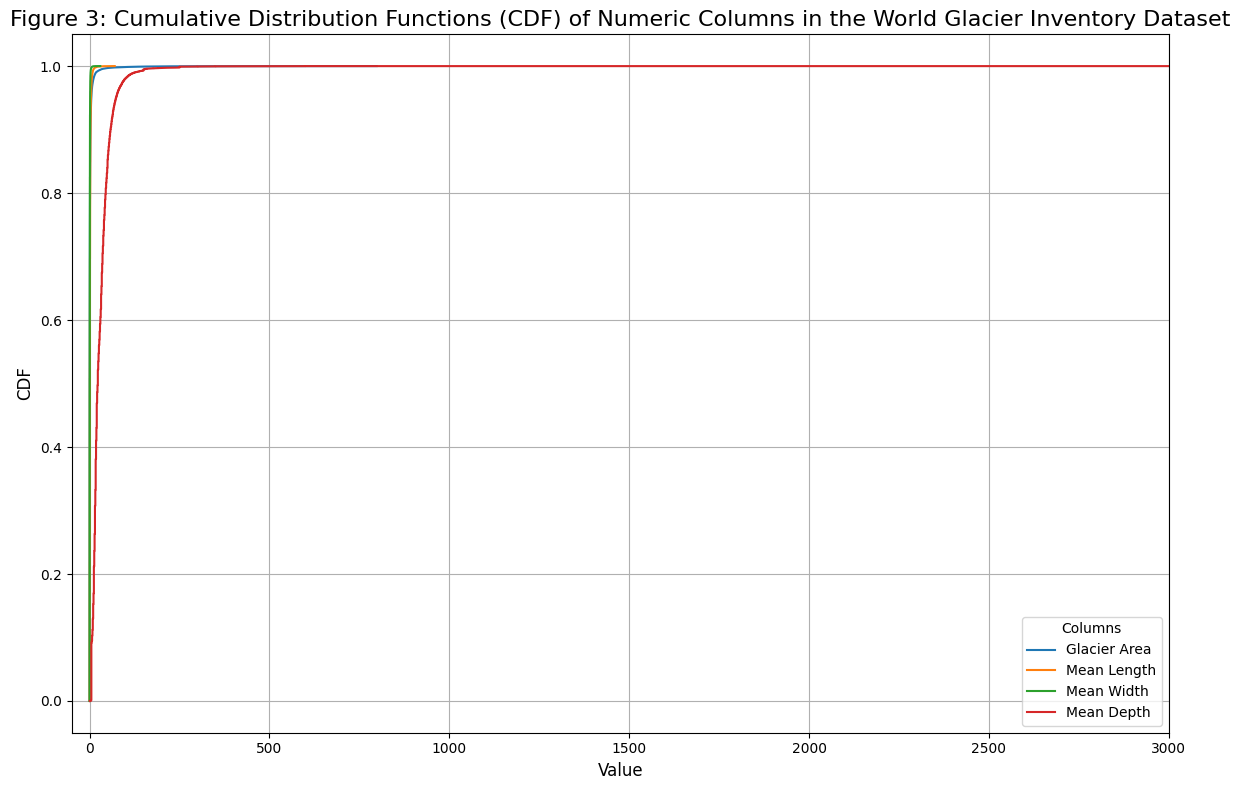

In [11]:
# Create a single CDF plot for all numeric columns
plt.figure(figsize=(12, 8))

for column_name in numeric_columns:
    # Sort the data
    wgidata = worldglacierinventorycondense[column_name].sort_values()

    # Calculate the CDF
    cdf = np.arange(1, len(wgidata) + 1) / len(wgidata)

    # Plot the CDF
    plt.plot(wgidata, cdf, label=column_name)

# Plot characteristics
plt.title('Figure 3: Cumulative Distribution Functions (CDF) of Numeric Columns in the World Glacier Inventory Dataset', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.xlim(-50, 3000)
plt.ylabel('CDF', fontsize=12)
plt.legend(title='Columns', fontsize=10, loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


The cumulative distribution function plot for the numeric columns in the World Glacier Inventory dataset shows that the majority of values for glacier area, mean length, mean width, and mean depth are concentrated at very low magnitudes, with nearly all data points reaching cumulative probabilities close to 1 at small values. This indicates that most glaciers in the dataset are small across all dimensions, emphasizing the prevalence of smaller glaciers. The nearly overlapping CDF curves suggest a similar distribution pattern across the variables, though slight differences at lower cumulative probabilities reflect variations in how the metrics scale for larger glaciers.

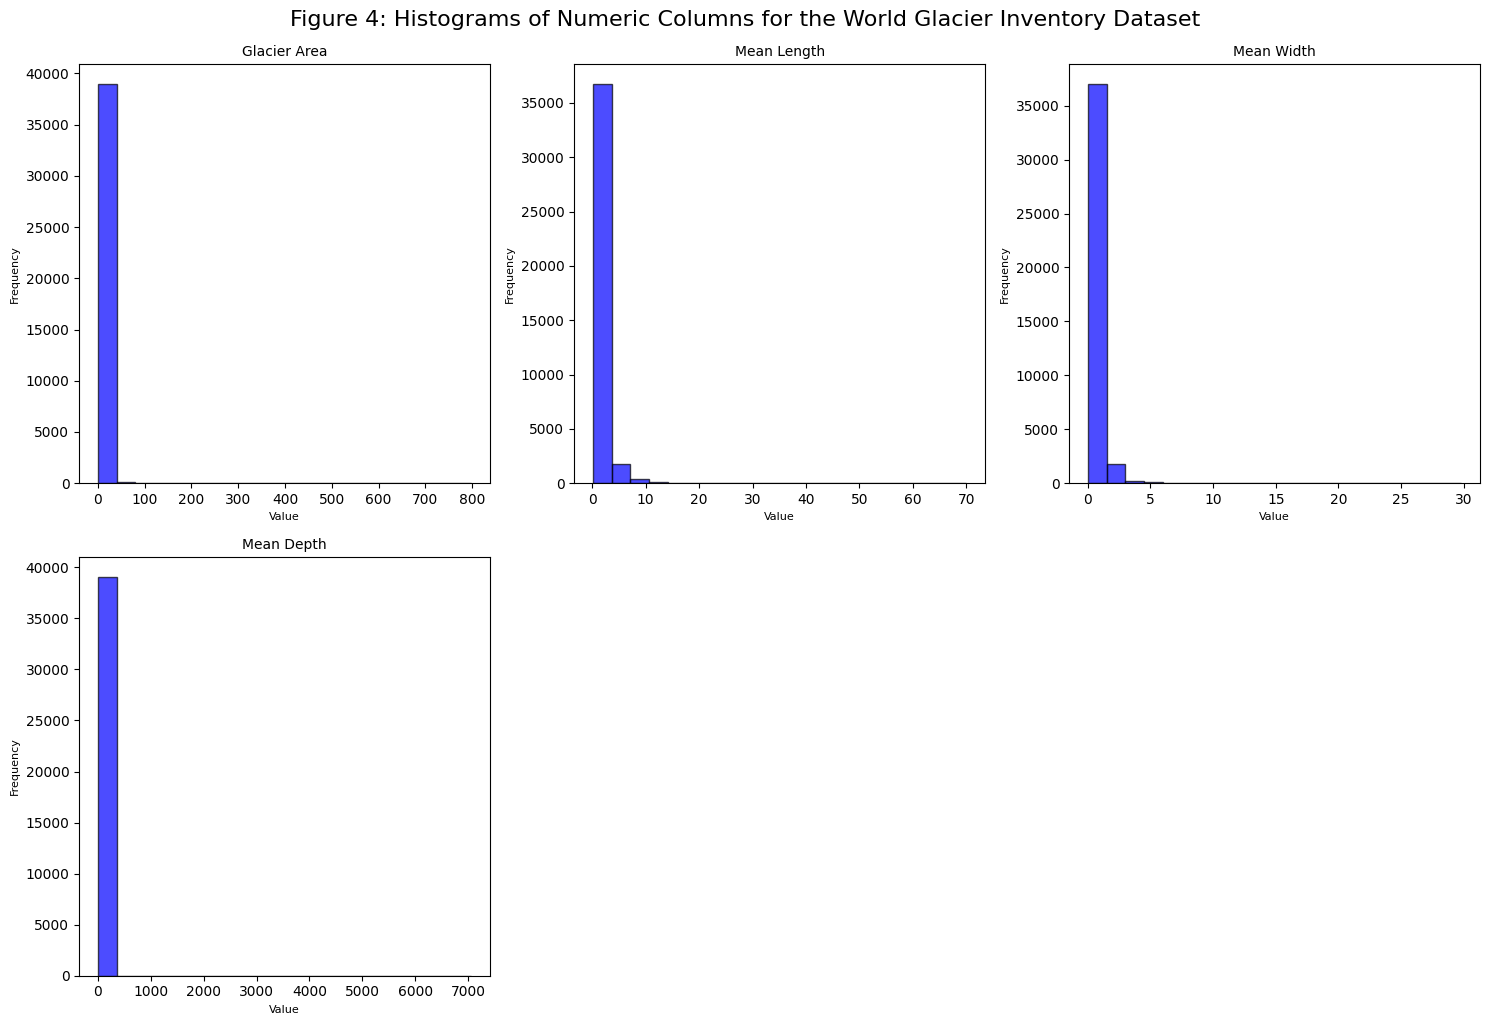

In [12]:
# Create histograms for each numeric column
numeric_columns = numeric_data.columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot((len(numeric_columns) + 2) // 3, 3, i)
    plt.hist(numeric_data[column], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(column, fontsize=10)
    plt.xlabel('Value', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.tight_layout()

plt.suptitle("Figure 4: Histograms of Numeric Columns for the World Glacier Inventory Dataset", fontsize=16, y=1.02)
plt.show()

The histograms reveal highly skewed distributions for glacier area, mean length, mean width, and mean depth, with most values concentrated near zero. This highlights the predominance of small glaciers in the dataset. Extending the x-axis to 3000 would provide a clearer view of outliers and the broader spread of data, though the frequency of larger values is minimal. These distributions emphasize the disproportionate representation of small glaciers relative to larger ones, which could reflect natural glacier size distributions or potential biases in the dataset's composition.

**Normalize the Data**

In [13]:
# Normalize the data for all the unsupervised ML methods
scaler = StandardScaler()
data_normalized = scaler.fit_transform(worldglacierinventorycondense)

**Unsupervised Method #1: K-Means**

In [14]:
# Define optimal number of clusters
optimal_k = 2

# Fit KMeans with the optimal number of clusters and calculate the silhouette score
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_optimal.fit_predict(data_normalized)

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(data_normalized, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.92


Here, I kicked out the elbow plot test (per feedback from Thomas Martin) instead played around with the silohuette score to determine the optimal number of clusters. Three clusters yields an `optimal_k` of 0.78, four clusters yields and `optimal_k` of 0.77, and two clusters yields an `optimal_k` of 0.92. Therefore, I decided to go with two as the optimal number of clusters for this k-means analysis.

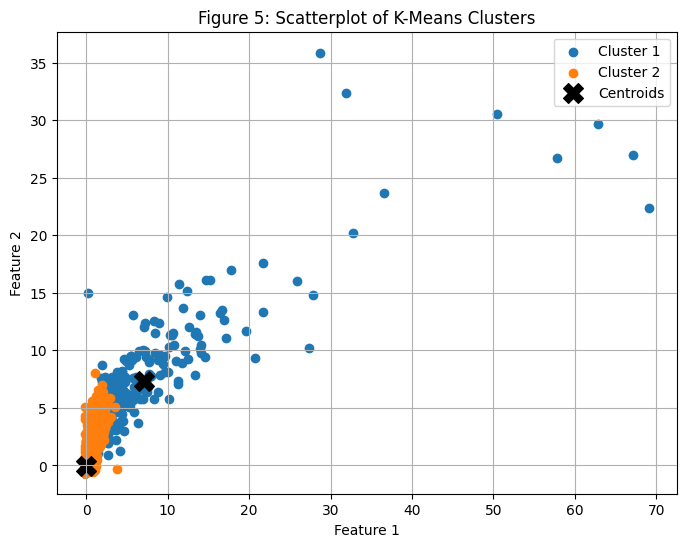

In [15]:
# Scatterplot of the clusters
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    cluster_points = data_normalized[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i + 1}")

# Cluster centroids
centroids = kmeans_optimal.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

plt.title(f"Figure 5: Scatterplot of K-Means Clusters")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

The scatterplot displays the results of K-means clustering, where the data points are divided into two clusters (Cluster 1 in blue and Cluster 2 in orange), with their respective centroids marked by black crosses. Cluster 1 contains the majority of the data points, spanning a wider range across both features, while Cluster 2 is more concentrated near the origin. The centroids indicate the central tendency of each cluster, with the Cluster 1 centroid further along Feature 1 and Feature 2. This suggests a meaningful separation between clusters based on the scaling of the features, though some overlap near the origin may indicate potential ambiguity or a gradient between clusters.

**Unsupervised Method #2: DBSCAN**

In [23]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_normalized)

# Number of clusters (excluding noise)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Number of clusters: 8
Number of noise points: 342


I played around the with the `eps value` and `min_samples` value but end up getting ridiculous amount of clusters (>30). With a higher number of clusters I get a better silhouette score, however, I am not sure how I am supposed to strike a balance here. If you have any thoughts, please let me know.


In [24]:
# Calculate silhouette score for DBSCAN
dbscan_silhouette = silhouette_score(data_normalized[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
print(f"Silhouette Score: {dbscan_silhouette:.2f}")

Silhouette Score: 0.23


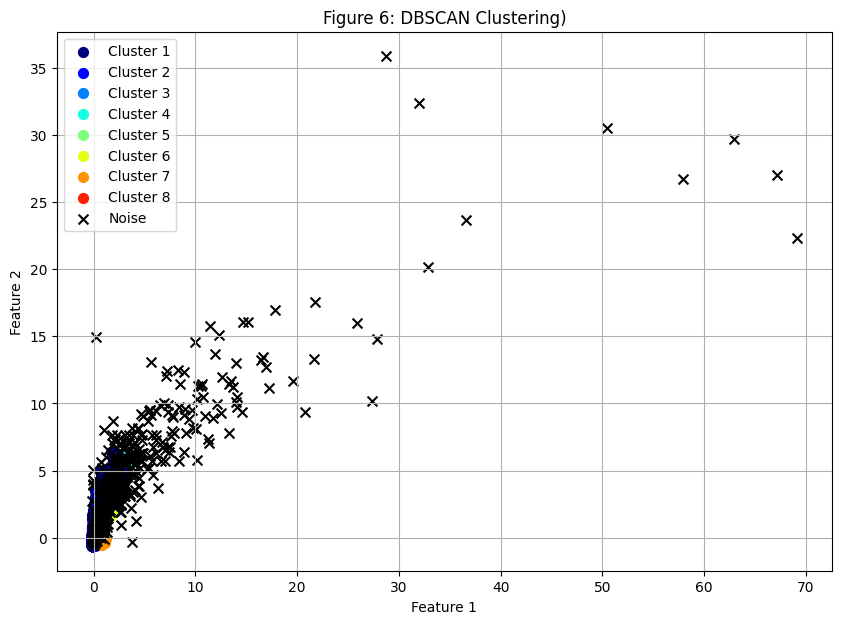

In [25]:
# Scatterplot for DBSCAN clustering results
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)

for label in unique_labels:
    if label == -1:
        # Noise points
        color = 'k'
        marker = 'x'
        label_name = 'Noise'
    else:
        # Cluster points
        color = plt.cm.jet(float(label) / n_clusters)
        marker = 'o'
        label_name = f'Cluster {label + 1}'

    cluster_points = data_normalized[dbscan_labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=label_name, marker=marker, s=50)

plt.title(f"Figure 6: DBSCAN Clustering)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

I got some feedback from my peer reviewer that it would be nice to view this plot with the noise points removed since the algorithm is marking so many things as noise (which is also a bit of a red flag in this analysis).


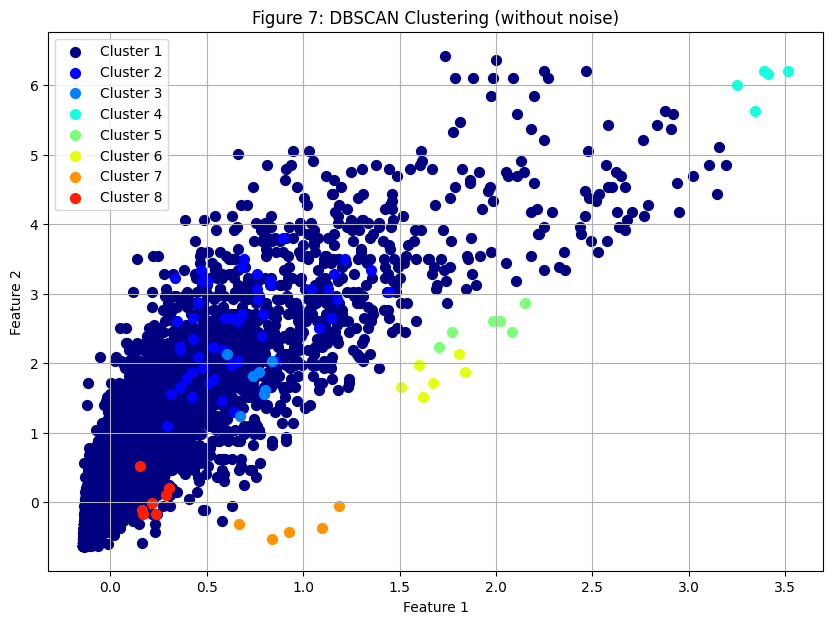

In [27]:
# Scatterplot for DBSCAN clustering results (without noise points)
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)

for label in unique_labels:
    if label == -1:
        # Skip noise points
        continue
    else:
        # Cluster points
        color = plt.cm.jet(float(label) / n_clusters)
        marker = 'o'
        label_name = f'Cluster {label + 1}'

    cluster_points = data_normalized[dbscan_labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=label_name, marker=marker, s=50)

plt.title(f"Figure 7: DBSCAN Clustering (without noise)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()


The DBSCAN clustering results depicted in this scatterplot show eight distinct clusters (labeled as Cluster 1 through Cluster 8) distributed across the feature space. Each cluster is represented by a unique color, and noise points (labeled as -1) have been excluded to focus solely on meaningful groupings. The clusters are well-separated, indicating the algorithm's effectiveness in identifying dense regions in the data.

Clusters 1, 2, and 3 dominate the lower left region, with a high density of points in close proximity, suggesting a primary grouping in the data. Clusters 4 through 8 are more sparsely distributed, representing smaller or more isolated groups. The clear separation between clusters highlights DBSCAN's capability to discern non-linear boundaries and find clusters of varying shapes and sizes. These results could be insightful for further exploration of feature relationships and underlying patterns within the dataset.









**Unsupervised Method #3: UMAP**

In [28]:
# Perform UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
data_umap = umap_reducer.fit_transform(data_normalized)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


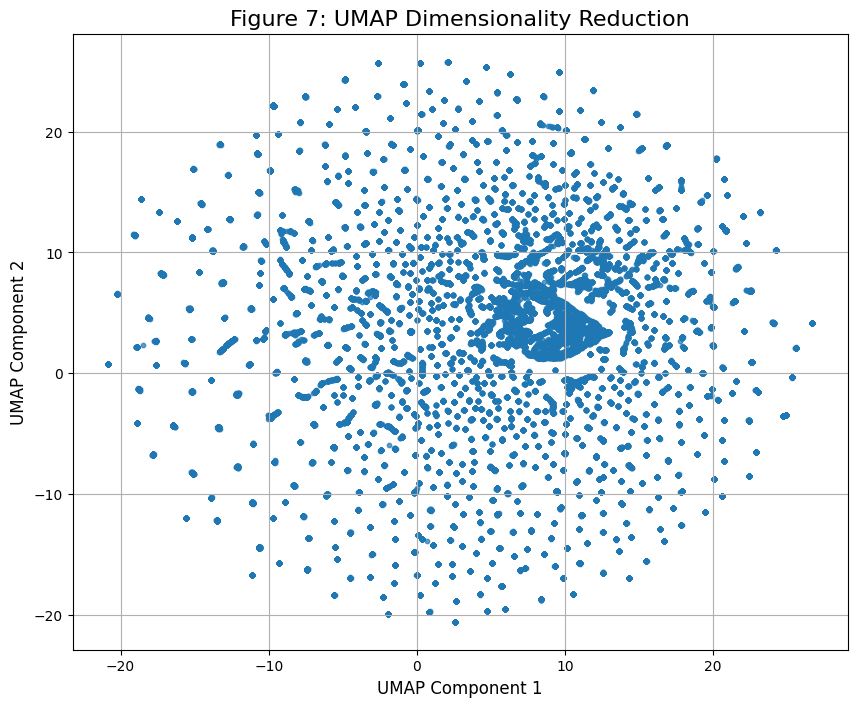

In [29]:
# Visualize results of UMAP dimensionality reduction
plt.figure(figsize=(10, 8))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, alpha=0.7)

# Plot characteristics
plt.title('Figure 7: UMAP Dimensionality Reduction', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True)
plt.show()

The scatterplot shows the results of dimensionality reduction using UMAP (Uniform Manifold Approximation and Projection). The two-dimensional embedding demonstrates how UMAP has projected the high-dimensional data into a lower-dimensional space while preserving its inherent structure and relationships.

In the visualization, a dense central region is evident, which may indicate a core grouping or cluster of data points with high similarity. Surrounding this dense area, there is a gradient of points extending outward, suggesting additional variation or potentially less similar data points. The broader distribution of points across the plot implies that the data spans multiple feature dimensions and contains diverse patterns.

UMAP's strength lies in maintaining local and global structures in the data, making this plot a helpful tool for identifying clusters or trends. This visualization could guide further steps, such as applying clustering algorithms or exploring relationships between the original features. However, further analysis is required to interpret the specific meaning of these groupings within the context of the dataset.

**Required Reflection Questions from Canvas**

*Which method did you like the most?*

I found K-Means to be the most intuitive and, therefore, my favorite method. My analysis identified a reasonable number of optimal clusters with a high silhouette score (0.92), suggesting that the clustering was meaningful and aligned well with the dataset.

*Which method did you like the least?*

The UMAP method was my least favorite. While I understand that it performs dimensionality reduction rather than clustering, I struggled to interpret the results and connect them to actionable insights or the other clustering methods like DBSCAN or K-Means.

*How did you score these unsupervised models? *

I evaluated the unsupervised models primarily using the silhouette score. This metric measures the quality of clustering, with values ranging from -1 to 1. A higher score indicates better-defined clusters. However, I could only apply the silhouette score to K-Means and DBSCAN, as UMAP is not inherently a clustering algorithm.

*Did the output align with your geologic understanding?*

The output partially aligns with geologic understanding. The clustering results, such as the dominance of smaller glaciers and the positive correlations between glacier dimensions, reflect known patterns in glacier morphology, where the majority of glaciers are small and dimensions scale proportionally. However, the presence of weakly separated clusters (as indicated by the silhouette score of 0.23 in DBSCAN) suggests that the clustering might not fully capture the variability or regional differences expected in glacier data. The high noise point count could align with the understanding that glaciers exhibit significant variability, but it may also point to the need for more refined clustering parameters to better align with geologic processes and glacier distribution patterns. Overall, while the results are consistent in highlighting size distribution trends, further analysis is needed to fully validate the clustering against geologic expectations.

*What did you want to learn more about?*

I want to deepen my understanding of UMAP and its applications. Specifically, I would like to explore how its results can be effectively interpreted and integrated with clustering techniques like K-Means or DBSCAN to uncover meaningful insights.

*Did you pre-process your data?*

Yes, I pre-processed the data to prepare it for machine learning. This involved selecting columns that contained useful data for ML purposes, removing any missing values, and normalizing the dataset using StandardScaler and its fit_transform method.

*What was a decision you were most unsure about?*

The decision I felt most uncertain about was determining the number of clusters to use. This is a common challenge in unsupervised machine learning, as there is often no definitive answer. We were not encouraged to use the Elbow Plot method, so instead I had to play around the `k_optimal` to get the best silhouette score value.